## SPED Session 1: Orientation Mapping & Vectors
**4D-STEM data analysis workshop**
**NTNU, Trondheim, June 12, 2024** - by Tina Bergh


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem as pxm
import orix

In [3]:
folder = '.\\'
file = 'SPED_Ag'
file_ending = '.hspy'

In [4]:
s = hs.load(folder+file+file_ending)

Load the results from yesterday's decomposition session "Machine_learning_SPED-Ag.ipynb". If you did not sucessfully run this notebook, download the .hspy files found in this folder and put them in the same folder on your PC as where your noetbook is. https://github.com/TEM-Gemini-Centre/nordtemhub_4DSTEMworkshop_2024/tree/main/Machine_learning_2_SPED-Ag

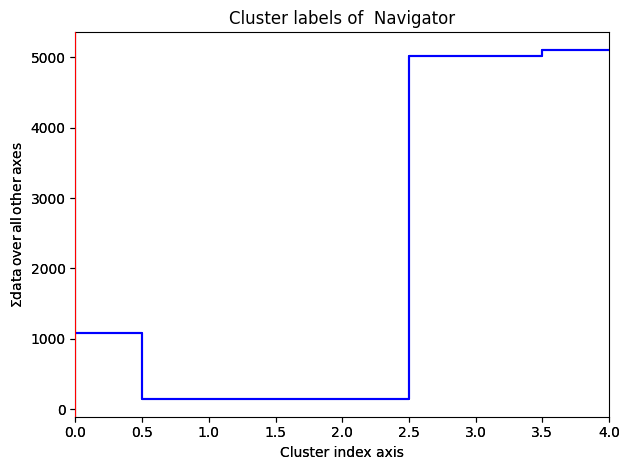

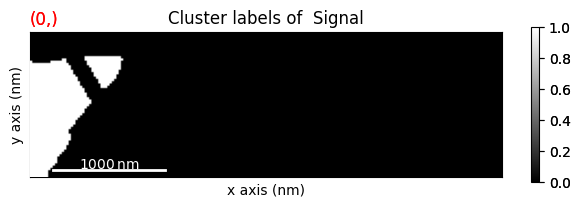

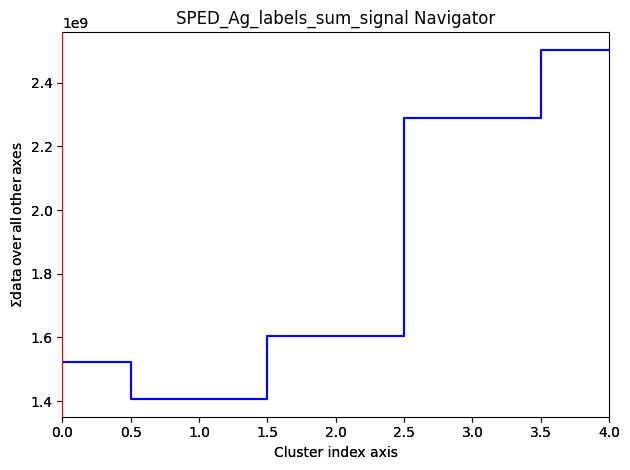

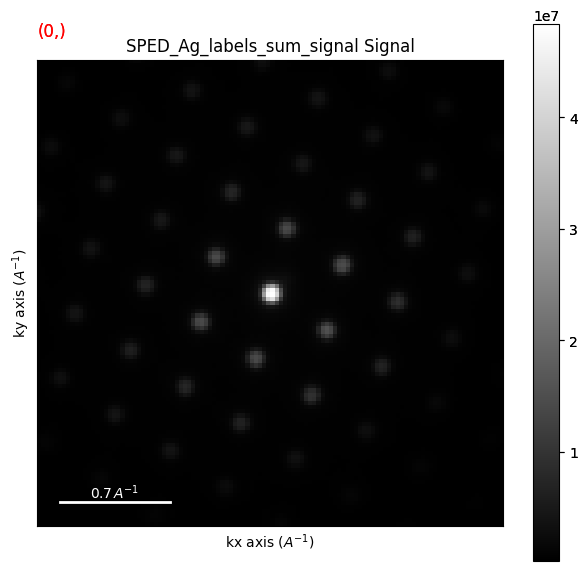

In [ ]:
labels = hs.load(folder+file+'_labels'+file_ending)
labels_sum_signal = hs.load(folder+file+'_labels_sum_signal'+file_ending)
hs.plot.plot_signals([labels, labels_sum_signal])

# Simulate template bank for silver

In [6]:
from diffpy.structure import Atom, Lattice, Structure

We define the face-centred cubic (fcc) unit cell of silver using the Phase class in orix. We need the lattice parameters, the fractional coordinates of the atoms in the basis, and the space group. 

In [7]:
a = 4.08 # lattice parameter for silver in Å
atoms = [Atom('Ag', [0, 0, 0]), Atom('Ag', [0.5, 0.5, 0]), Atom('Ag', [0.5, 0, 0.5]), Atom('Ag', [0, 0.5, 0.5])]
lattice = Lattice(a, a, a, 90, 90, 90)
phase = orix.crystal_map.Phase(name='Ag', space_group=225, structure=Structure(atoms, lattice))
phase

<name: Ag. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

We define a grid of rotations that we will use for simulating templates later. We need to set the anular resolution in degrees and supply the point group of silver. The grid will only include different zone axes and no in-plane rotations, which reduces the number of unique rotations a lot.

In [8]:
angular_resolution = 0.5
grid = orix.sampling.get_sample_reduced_fundamental(
    angular_resolution,             
    point_group=phase.point_group,  
    )
grid

Rotation (4186,)
[[ 0.7071 -0.      0.     -0.7071]
 [ 0.7071 -0.0031  0.0031 -0.7071]
 [ 0.7071 -0.0062  0.0062 -0.7071]
 ...
 [ 0.8192 -0.4198  0.1782 -0.3477]
 [ 0.8198 -0.4223  0.1771 -0.3438]
 [ 0.8205 -0.4247  0.1759 -0.3399]]

We can define the grid of rotations as orientations and plot them on the inverse pole figure (IPF) to see how we sample orientations across the symmetry reduced fundamental sector.

Orientation (4186,) m-3m
[[ 0.7071 -0.      0.     -0.7071]
 [ 0.7071 -0.0031  0.0031 -0.7071]
 [ 0.7071 -0.0062  0.0062 -0.7071]
 ...
 [ 0.8192 -0.4198  0.1782 -0.3477]
 [ 0.8198 -0.4223  0.1771 -0.3438]
 [ 0.8205 -0.4247  0.1759 -0.3399]]

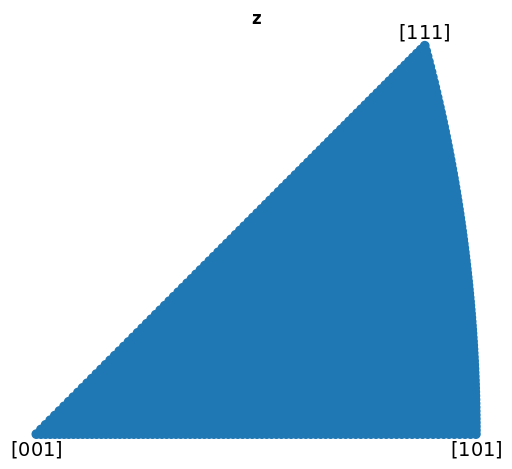

In [9]:
orientations = orix.quaternion.Orientation(grid, symmetry=phase.point_group)
orientations.scatter('ipf')
orientations

We define a simulation generator that takes the precession angle (1 degree) and minimum intensity of spots to keep in the simulated templates. 

In [ ]:
from diffsims.generators.simulation_generator import SimulationGenerator

In [10]:
simgen = SimulationGenerator(precession_angle=1., minimum_intensity=1e-5)

We calculate the simulated templates based on the crystal structure we defined earlier, the simulation generator and the grid of rotations. We have to specify how far out into reciprocal space we want to simulate diffraction spots for in calibrated units (Å-1). We also need to specify the maximum excitation error in units Å-1 (s-value), which we tend to find by trial and error.

In [11]:
simulations = simgen.calculate_diffraction2d(
    phase=phase,                # Which phase(s) to simulate for
    rotation=grid,              # Which orientations to simulate for.
    reciprocal_radius=1.5,      # Max radius to consider, in reciprocal Ångström.
    with_direct_beam=False,     # Whether to include the direct beam in simulations.
    max_excitation_error=0.01,  # Maximal excitation error s, in reciprocal Ångström, used for rel-rod length.
    )

Plot all the simulations, with the spot size indicating the spot intensity.

(<Axes: xlabel='$\\AA^{-1}$', ylabel='$\\AA^{-1}$'>,
 <matplotlib.collections.PathCollection at 0x1e0545663f0>)

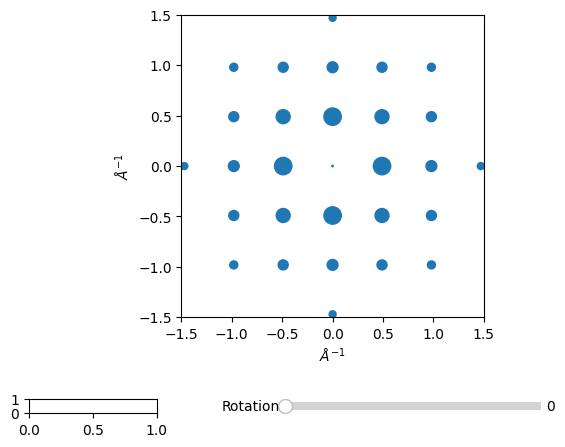

In [12]:
simulations.plot(interactive=True)

## Template matching of the summed signals

Perform 2D azimuthal integration of the summed patterns to get a polar representation of the patterns. Specify the number of pixels in the resulting polar signal. 

[########################################] | 100% Completed | 103.25 ms


<PolarDiffraction2D, title: , dimensions: (5|360, 112)>

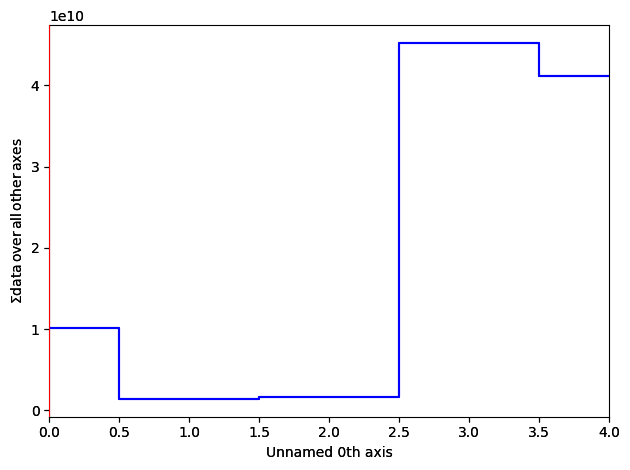

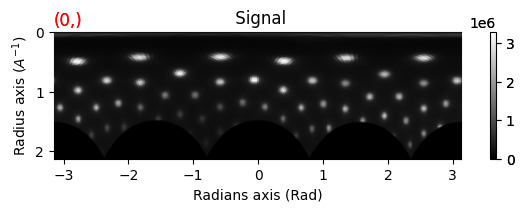

In [14]:
labels_pol = labels_sum_signal.get_azimuthal_integral2d(npt=112)
labels_pol.plot()
labels_pol

Template match the polar dataset. Specify how many of the templates to save matching results for in n_best. Since we only look at five patterns now, we can save the matching results for all templates. We can also specify the frac_keep, which is 0.1 by default. By defualt, the template matching will run on the integrated 1D pattern and then do a full matching on the polar 2D patterns only for the fraction of the best 1D matches specified in frac_keep. Again, since we have only five patterns, we can perform full matching on all the patterns.

In [15]:
results = labels_pol.get_orientation(simulations, n_best=grid.size, frac_keep=1.0)
results

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 4.55 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 103.24 ms


<OrientationMap, title: , dimensions: (5|4, 4186)>

Plot the polar reprojected dataset with the best matching template spots on top as red circles. Inspect if the experimental spots lie within the template markers. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


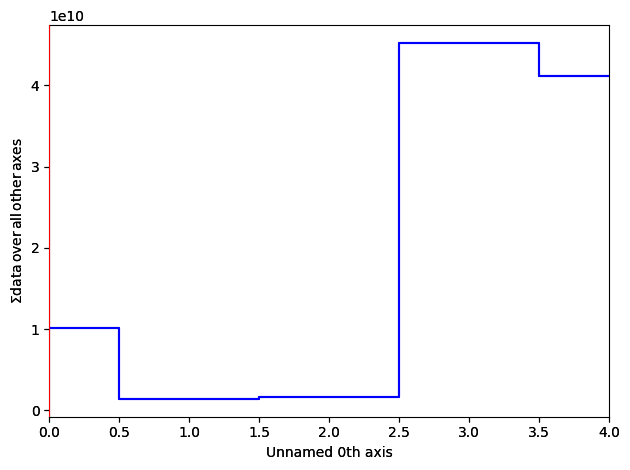

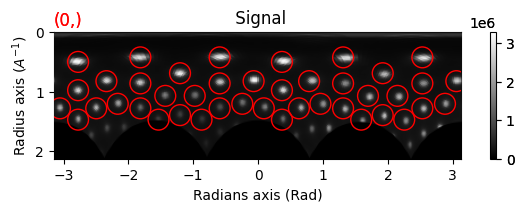

In [16]:
labels_pol.plot()
labels_pol.add_marker(results.to_single_phase_polar_markers(
    signal_axes=labels_pol.axes_manager.signal_axes))

Plot the original data with the template markers for 2D patterns on top. Again, inspect if they correspond well. Note that there is a bug in the hkl indices plotted in the pyxem 0.19.0 version, but there is a bugfix (thanks, Carter) that resolves this in the 0.19.1 version. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


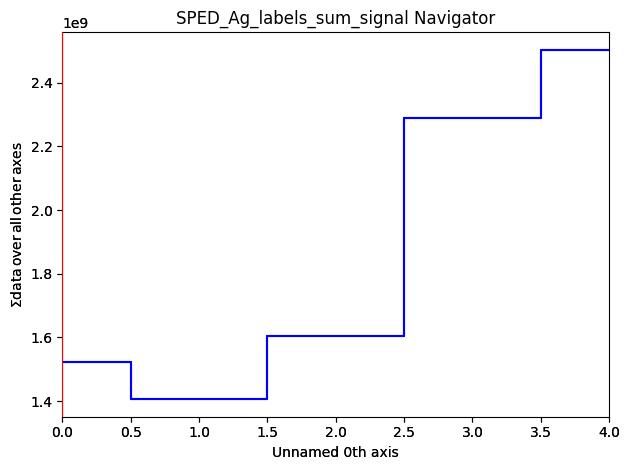

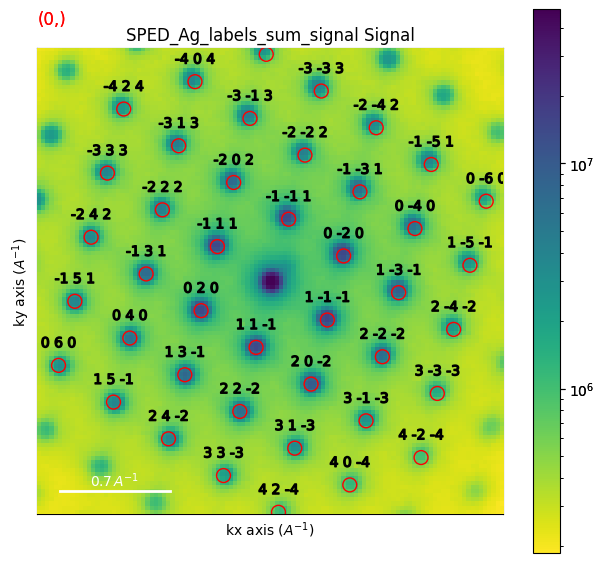

In [17]:
labels_sum_signal.plot(cmap='viridis_r', norm='log')
labels_sum_signal.add_marker(results.to_markers(annotate=True))

We pick one pattern (specified by the index i) and plot the correlation values for all the templates on top of the IPF. Here, we see that only one region in the IPF lights up, which makes us more confident that the template matching routine was able to find the best match. In other cases, it might be that two (or more) regions light up, which indicates that two (or more) zone axes match almost as well. 

(Rotation (1,)
 [[ 0.9106 -0.1558  0.0646 -0.3772]],
 0,
 DiffractingVector (14,), Ag (m-3m)
 [[ 5. -1. -1.]
  [ 4.  4. -2.]
  [ 4. -4.  0.]
  [ 3.  1. -1.]
  [ 2. -2.  0.]
  [ 1.  3. -1.]
  [ 1. -5.  1.]
  [-1.  5. -1.]
  [-1. -3.  1.]
  [-2.  2. -0.]
  [-3. -1.  1.]
  [-4.  4. -0.]
  [-4. -4.  2.]
  [-5.  1.  1.]])

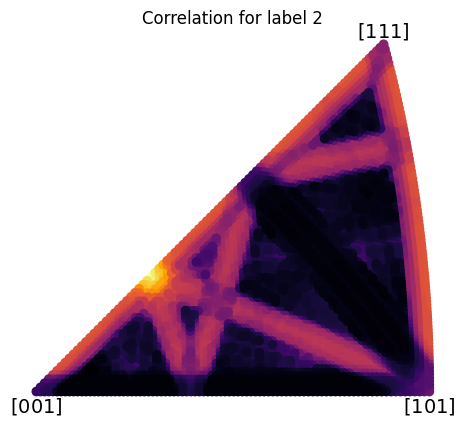

In [18]:
i = 2 # 0

correlations_i = results.inav[i].data[:, 1]
template_indices_i = (results.inav[i].data[:, 0]).astype('int16')
orientations_i = orientations[template_indices_i]
euler_angles_i = orientations_i.to_euler()

fig = plt.figure()
ax = fig.add_subplot(111, projection="ipf", symmetry=phase.point_group)
ax.scatter(orientations_i, c=correlations_i, cmap='inferno')
ax.set_title('Correlation for label '+str(i))

# Print the hkl indices of the best matching simulation:
sim_i = simulations.get_simulation(template_indices_i[0])
sim_i

We can see that we have four silver patterns of zone axis [101]. Then we have one other pattern. Can you directly say which zone axis this is? Otherwise, we can calculate it by using the cross product between two indices. 

In [19]:
hkl1 = (1, 3, -1)
hkl2 = (3, 1, -1)
zone_axis_i = np.cross(hkl1, hkl2)
zone_axis_i/-2

array([1., 1., 4.])

Or multiply the orientation by the optical axis to find the zone axis. (Optional)


In [ ]:
from orix.vector import Miller
optical_axis = Miller(uvw=[0, 0, 1], phase=phase)
(sim_i[0] * optical_axis).round()

### Look at the found orientations

Extract one orientation for each of our five patterns, corresponding to the best matching templates.

In [20]:
loris = results.to_single_phase_orientations()
loris_best = loris[:, 0]
loris_best

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 102.69 ms


Orientation (5,) m-3m
[[ 0.7614  0.2168  0.3154  0.5233]
 [ 0.9237 -0.0067  0.3826 -0.0161]
 [ 0.6    -0.022   0.1672 -0.782 ]
 [ 0.8924  0.099   0.3696  0.2391]
 [ 0.8654 -0.134   0.3584 -0.3235]]

Plot these five orientations on the IPF. Here we see our two zone axes. If we plot the orientations in the axis-angle representation ("axangle" (default)), we can see that the five orientations are indeed different. The four [101] patterns all have a different in-plane rotation value. This we can also see if we print the first Euler angles in degrees.

array([[201.        ,  45.        ,  90.        ],
       [272.        ,  45.        ,  90.        ],
       [330.        ,  19.42280539, 135.        ],
       [240.        ,  45.        ,  90.        ],
       [311.        ,  45.        ,  90.        ]])

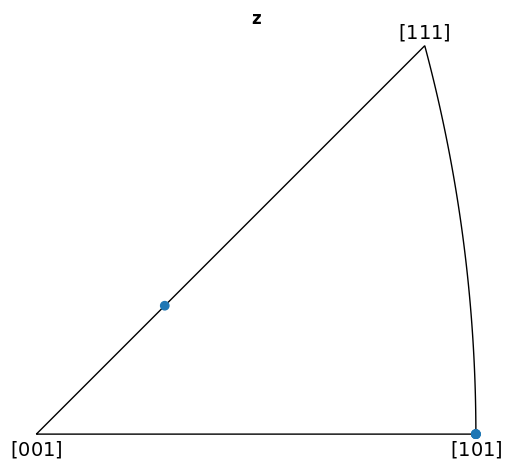

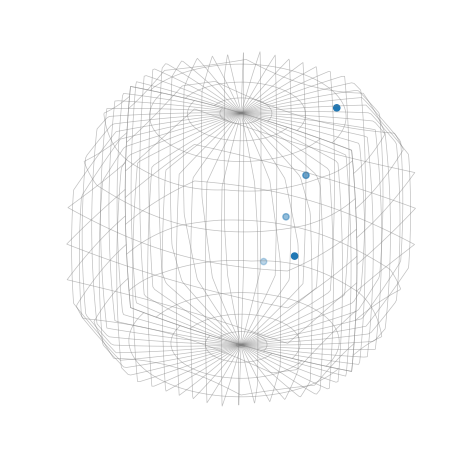

In [21]:
loris_best.scatter('ipf')
loris_best.scatter()
loris_euler = loris_best.to_euler(degrees=True)
loris_euler

As you may suspect after looking at this dataset for a while, we have twins! We can calculate the smallest angle of rotation that is needed to get from one orientation to another. We do this for our five orientations and see that some orientations are related by a 60 degree rotation, which indicates twinning.

In [22]:
loris_ang = loris_best.angle_with_outer(loris_best, degrees=True)
loris_ang

array([[ 0.        , 60.00167811, 35.42815218, 39.        , 60.0021131 ],
       [60.00167811,  0.        , 38.19197515, 32.        , 39.        ],
       [35.42815218, 38.19197515,  0.        , 60.00001772, 39.20432224],
       [39.        , 32.        , 60.00001772,  0.        , 60.00167811],
       [60.0021131 , 39.        , 39.20432224, 60.00167811,  0.        ]])

We can plot the found angles in a histogram.

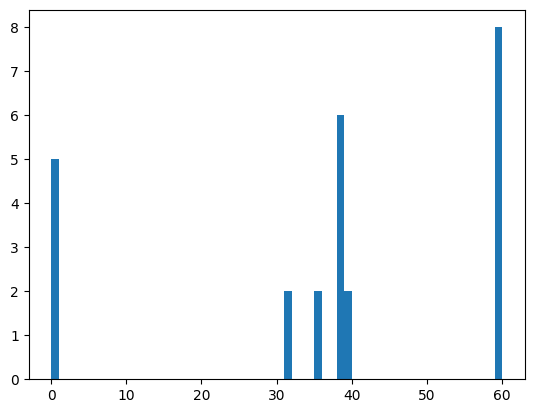

In [23]:
plt.figure()
plt.hist(loris_ang.flatten(), bins=60);

## Sample orientations only around the found zone axes

We have found the two unique zone axes in our dataset, [101] and [114]. Later, we want to perform template matching on the original dataset, but then we do not need to include all orientations across the fundamental sector. Rather we can reduce the grid to only include orientations within a certain angle from these zone axes. To acconplish this, we write a small function. 

In [24]:
from orix.vector import Miller, Vector3d

In [25]:
def reduce_beam_directions(orientations, zone_axis, angle_threshold):
    '''
    Redue the orientation grid to only include orientations close to a zone axis.
    
    Parameters
    ----------
    orientations: orix.quaternion.Orientation
        Orientations sampling the fundamental sector.
    zone_axis : np.array
        Zone axis [u, v, w] to sample around.
    angle_threshold : float
        Only orientations within angle_threshold (in degrees) will be kept.

    Returns
    ----------
    reduced_grid: orix.quaternion.Orientation
        Orientations only including those close to the zone axis.
    
    '''
    angles = (orientations * Vector3d.zvector()).angle_with(zone_axis)
    reduced_grid = orientations[angles <= np.deg2rad(angle_threshold)]
    return reduced_grid

Get a reduced grid that only samples around the [101] zone axis. 

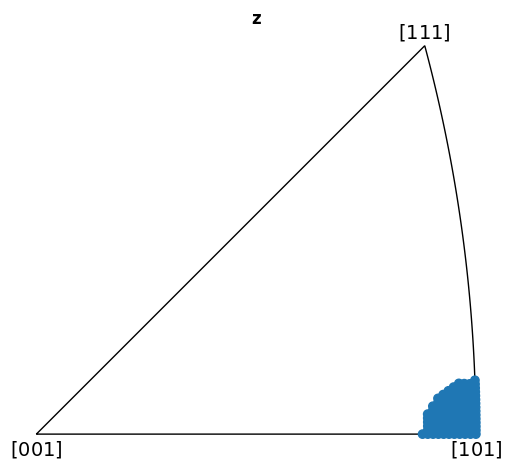

In [26]:
zone_axis_101 = orix.vector.Miller(uvw=(1,0,1), phase=phase)
orientations_around_101 = reduce_beam_directions(orientations, zone_axis_101, 5)
orientations_around_101.scatter('ipf')

Get a reduced grid that only samples around the [114] zone axis. 

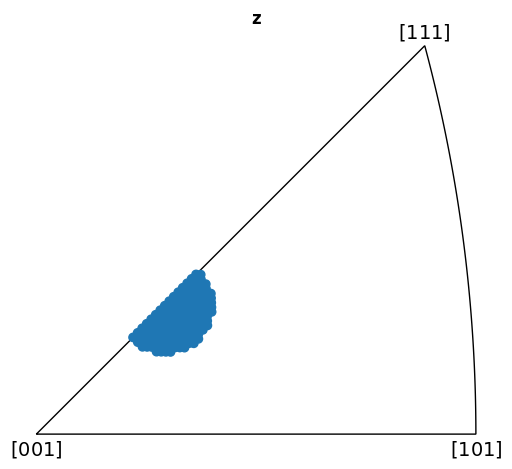

In [27]:
zone_axis_114 = orix.vector.Miller(uvw=(1,1,4), phase=phase)
orientations_around_114 = reduce_beam_directions(orientations, zone_axis_114, 5)
orientations_around_114.scatter('ipf')

Combine these two reduced grids to get orientations around the [101] and [114] zone axes. 

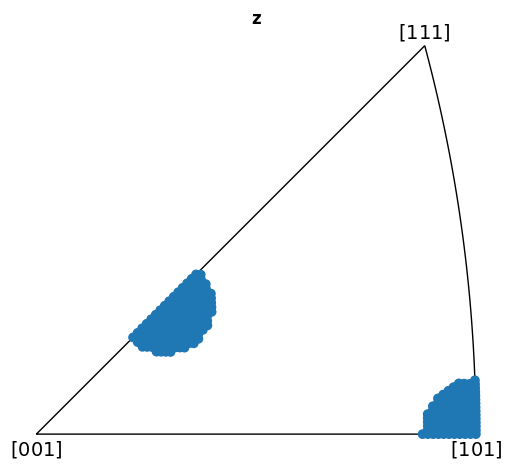

In [28]:
zone_axes_grid = np.concatenate((orientations_around_101.data, orientations_around_114.data))
orientations_zone_axes = orix.quaternion.Orientation(zone_axes_grid, symmetry=phase.point_group)
orientations_zone_axes.scatter('ipf')

Calculate a new template bank for this new grid. Use the same simulation parameters as previously. 

In [29]:
simulations_zone_axes = simgen.calculate_diffraction2d(
    phase=phase,                # Which phase(s) to simulate for
    rotation=orientations_zone_axes,              # Which orientations to simulate for. Can be multiple instances corresponding to multiple phases
    reciprocal_radius=1.5,      # Max radius to consider, in reciprocal Ångström
    with_direct_beam=False,     # Whether to include the direct beam in simulations
    max_excitation_error=0.01,  # Maximal excitation error s, in reciprocal Ångström, used for rel-rod length
    )

(<Axes: xlabel='$\\AA^{-1}$', ylabel='$\\AA^{-1}$'>,
 <matplotlib.collections.PathCollection at 0x1e083375610>)

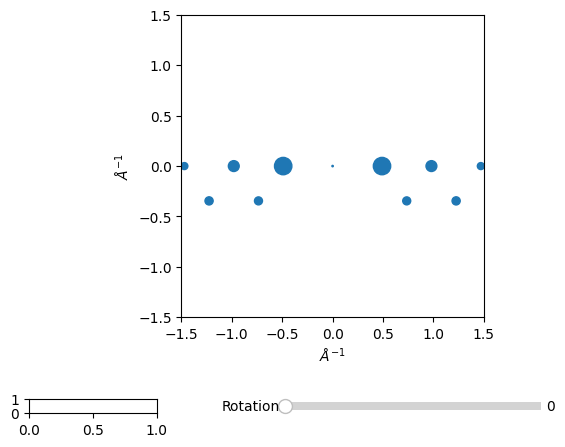

In [30]:
simulations_zone_axes.plot(interactive=True)

## Diffraction vectors

Now we will pre-process our original dataset before we do the template matching on the whole dataset. We can use one of the various background subtraction methods, which can be applied to either the 2D patterns or the polar patterns. Here, we will do an alternative approach where we exploit that we can find the diffraction vectors by peak finding.

First, we will take a disk and calculate the correction of this disk across each and every pattern, in essence template matching with a small disk. This will give maxima in the center of each diffraction spot. 

[########################################] | 100% Completed | 12.30 s


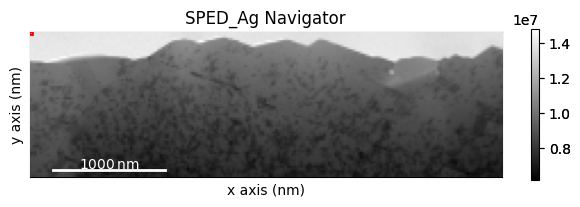

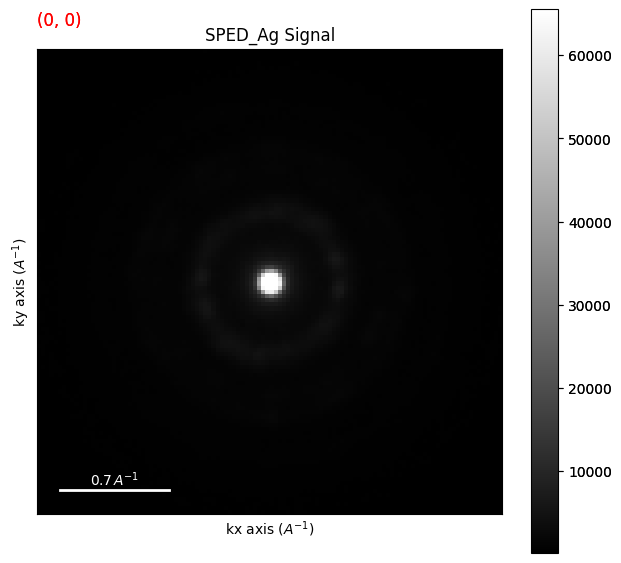

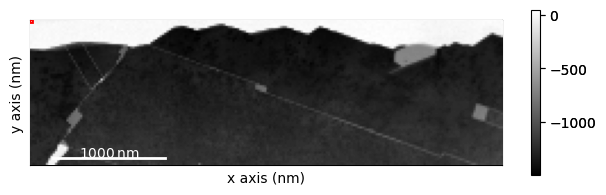

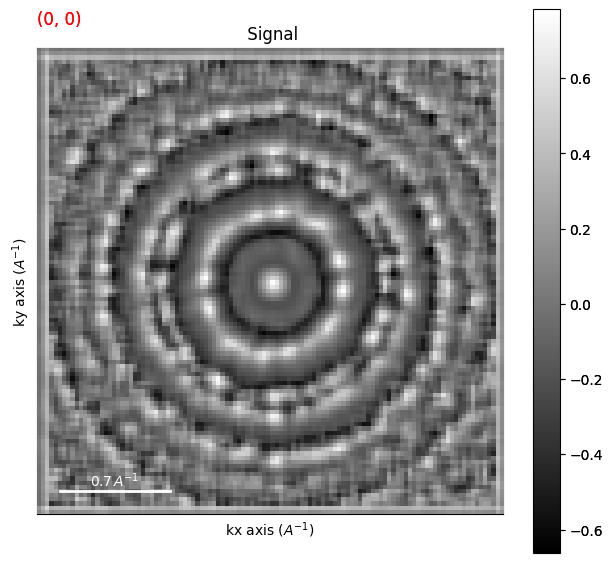

In [31]:
st = s.template_match_disk(disk_r=2.5, subtract_min=False)
hs.plot.plot_signals([s, st])

Then we will use a peak finder to find the diffraction spot center positions. There is an interactive peak finder that you can use to experiment with the peak finding methods and parameters. It is currently not plotting the markers unfourtunately, so we will not use it here, but in the futre you could test it using: st.find_peaks(interactive=True). 

Here we will pick one pattern and inspect the peak finding results on that first. 

[########################################] | 100% Completed | 103.63 ms
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 103.33 ms
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 102.69 ms


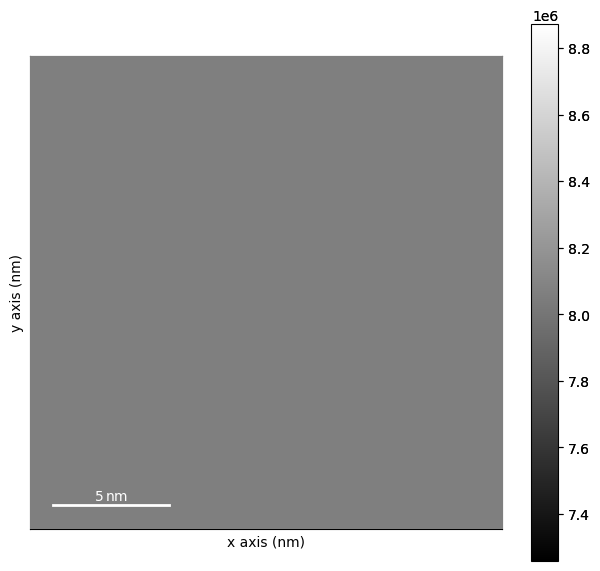

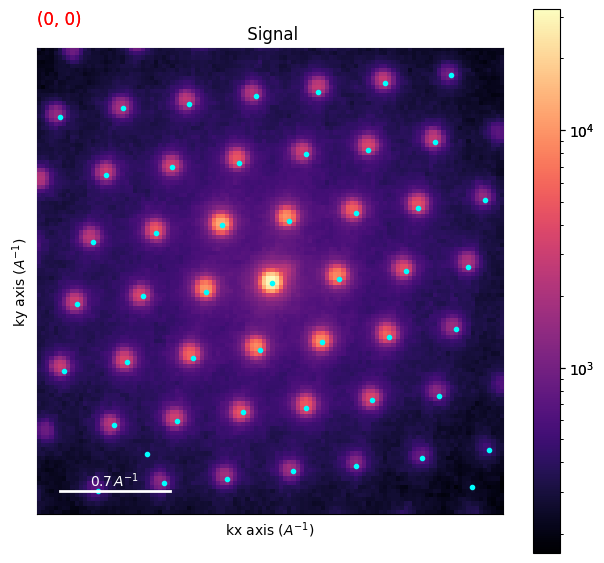

In [32]:
i, j = 42, 42
# i, j = 12, 60
# i, j = 166, 16
s_ij = s.inav[i:i+1, j:j+1]
st_ij = st.inav[i:i+1, j:j+1]

st_ij_peaks = st_ij.get_diffraction_vectors(min_distance=3, threshold_abs=0.3)

m = st_ij_peaks.to_markers(sizes=3, color='cyan')
s_ij.plot(cmap='magma', norm='log')
s_ij.add_marker(m)

We will then find the diffraction vectors by peak finding on all the patterns.

In [33]:
vectors = st.get_diffraction_vectors(min_distance=3, threshold_abs=0.3)
vectors

[########################################] | 100% Completed | 37.18 s
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 242.88 ms


<DiffractionVectors, title: , dimensions: (208, 64|ragged)>

We then define markers so that we can visualise the found peak positions on top of the dataset. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 102.89 ms


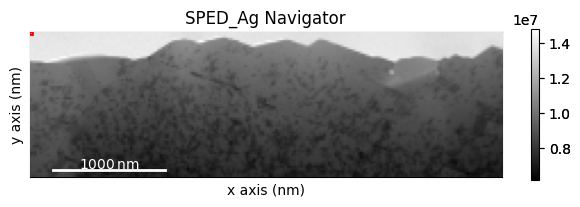

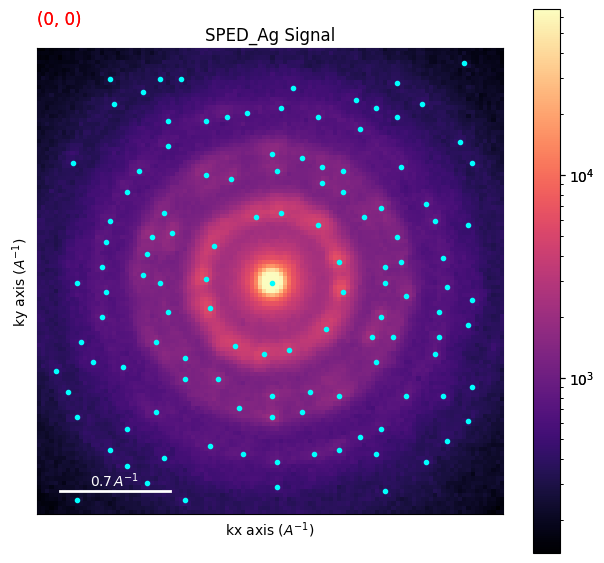

In [34]:
m = vectors.to_markers(sizes=3, color='cyan')
s.plot(cmap='magma', norm='log')
s.add_marker(m)

We can also plot a map of the navigation space showing the number of found vectors for each navigation position. Now we can see that all overlap regions light up, since these contain many more diffraction spots due to double diffraction. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 102.71 ms
WARNING | Hyperspy | `signal_type='signal2d'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


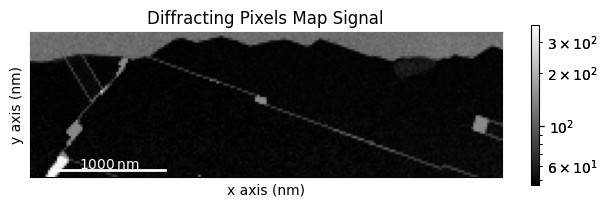

In [35]:
dpm = vectors.get_diffracting_pixels_map()
dpm.plot(norm='log')

We can also extract the magnitudes of all the vectors and plot them in a histogram. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 247.48 ms


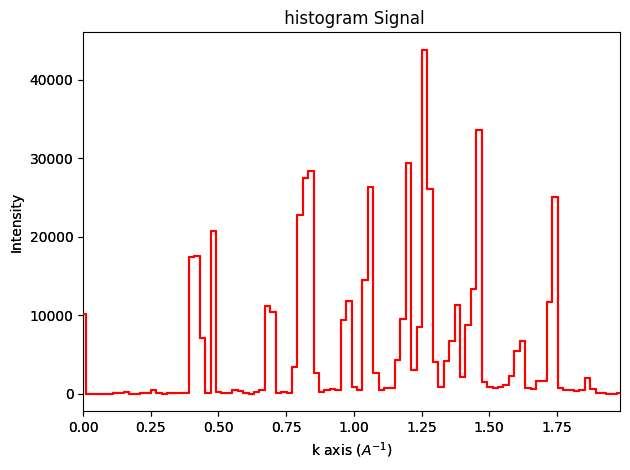

In [36]:
vectors_mags_hist = vectors.inav[:, 15:].get_magnitude_histogram(bins=100)
vectors_mags_hist.plot()

Simulate the 1D pattern and plot it.

In [ ]:
sim1d = simgen.calculate_diffraction1d(phase, 1.5, 1e-5)
sim1d.plot()

We can then define the inverse d-spacings values that we would expect for fcc silver and plot them on top of the histogram of vector magnitudes, to verify that the crystal structure and calibration are as expected, before we do the full teplate matching routine. 

In [37]:
hkls = ((1,1,1), (0,0,2), (0,2,2), (1,1,3), (2,2,2), (0,0,4), (1,3,3), (0,2,4), (1,1,5), (0,0,6))
hkls_texts = [str(hkl[0])+','+str(hkl[1])+','+str(hkl[2])  for hkl in hkls]

inverse_ds = np.array([1/np.sqrt(a**2/(hkl[0]**2+hkl[1]**2+hkl[2]**2)) for hkl in hkls])
np.set_printoptions(precision=2)
print('d-spacings in Å: ', 1/inverse_ds)
print('inverse d-spacings in Å-1: ', inverse_ds)

hkls_texts_pos = np.stack([inverse_ds, np.zeros_like(inverse_ds)], axis=-1)

vectors_mags_hist.plot()

mi = hs.plot.markers.VerticalLines(offsets=inverse_ds, linewidth=1, colors='k')
vectors_mags_hist.add_marker(mi)

mit = hs.plot.markers.Texts(offsets=hkls_texts_pos, texts=hkls_texts, color='blue')
vectors_mags_hist.add_marker(mit)

d-spacings in Å:  [2.36 2.04 1.44 1.23 1.18 1.02 0.94 0.91 0.79 0.68]
inverse d-spacings in Å-1:  [0.42 0.49 0.69 0.81 0.85 0.98 1.07 1.09 1.27 1.47]


Pre-process the original dataset by masking based on the found diffraction vectors. This is an alternative to one of the various background subtraction methods that can be done prior to template matching. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 66.21 s


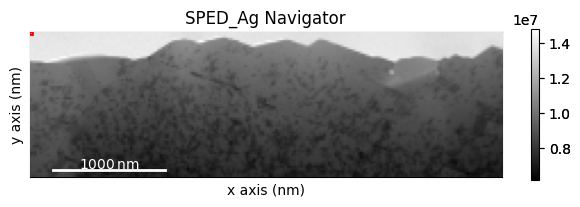

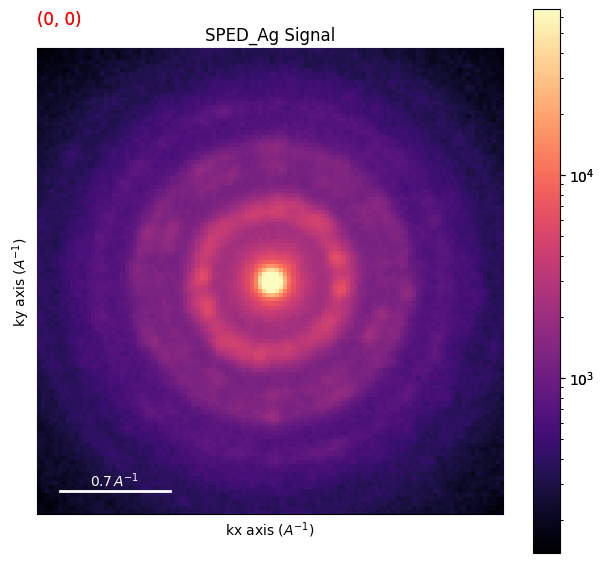

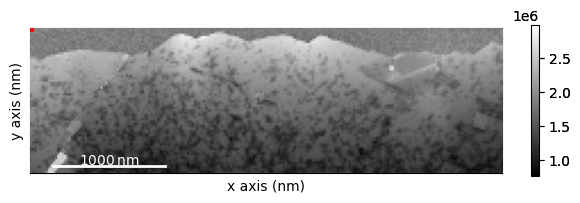

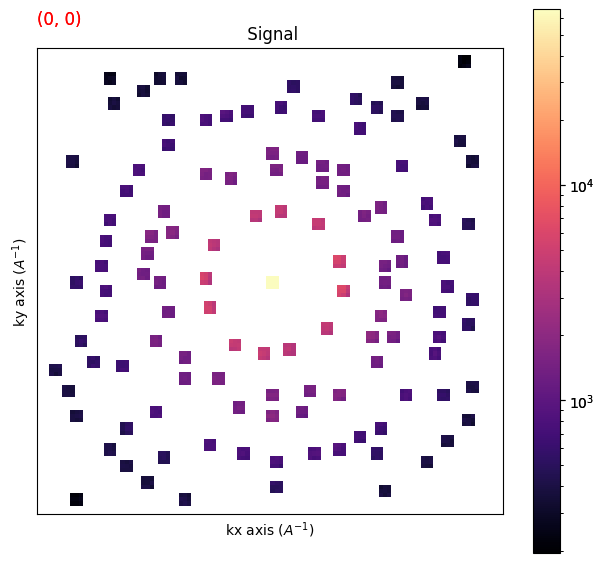

In [38]:
vectors_masks = vectors.to_mask(disk_r = 2)
s_masked = s * vectors_masks
hs.plot.plot_signals([s, s_masked], norm='log', cmap='magma')

# Orientation mapping

We calculate the polar reprojection of the pre-processed dataset.

[########################################] | 100% Completed | 20.36 s


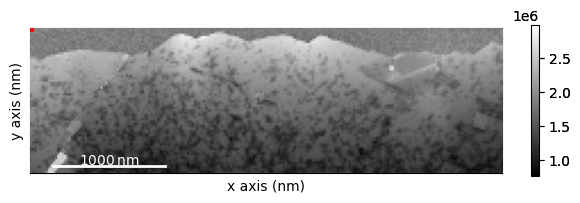

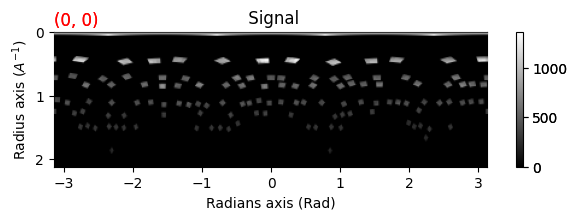

In [39]:
s_masked_pol = s_masked.get_azimuthal_integral2d(npt=112)
s_masked_pol.plot()

Then we perform the template matching based on the template bank that includes simulations close to our two zone axes. We will now only save the best match for each pattern and run the full template matching only on the 50% best patterns from the fast matching (done in 1D). 

In [40]:
s_results = s_masked_pol.get_orientation(simulations_zone_axes, n_best=1, frac_keep=0.5)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 86.19 s
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 208.87 ms


We can plot the template spots as markers on top of the polar signal.

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


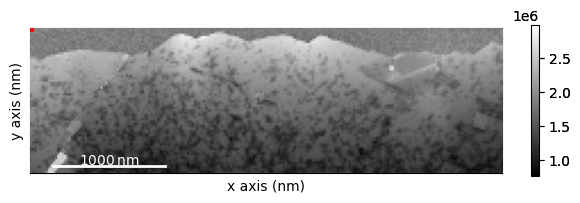

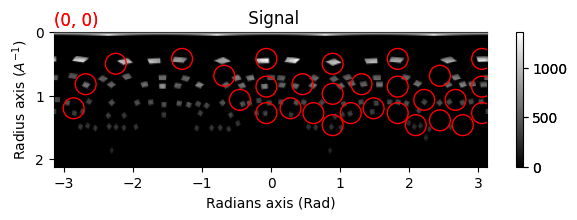

In [41]:
s_masked_pol.plot()
s_masked_pol.add_marker(s_results.to_single_phase_polar_markers(
    signal_axes=s_masked_pol.axes_manager.signal_axes))

We also plot the original dataset with the best matching template spots as markers on top. 

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 2.24 ss


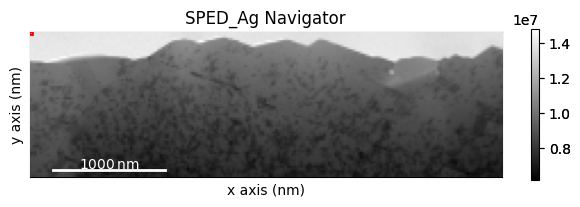

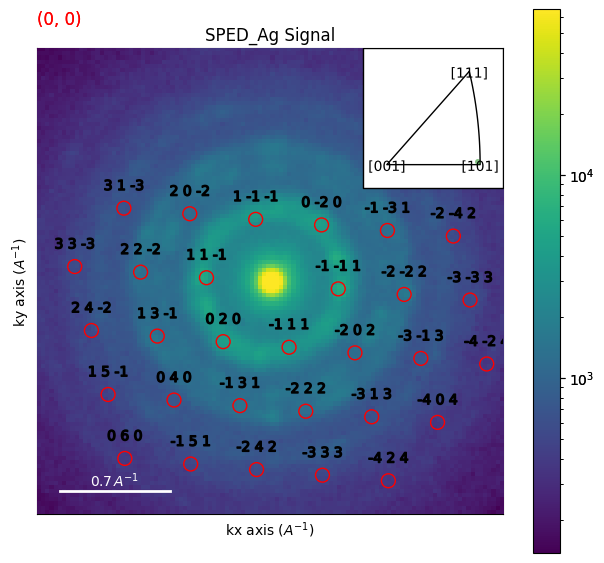

In [42]:
s.plot(cmap='viridis', norm='log')
s.add_marker(s_results.to_markers(annotate=True))
s.add_marker(s_results.to_ipf_markers())

Extract the results from template matching and put it in a crystal map class, which enables us to use some convenient functions later. We extract the orientations and the correlation scores as well. 

In [43]:
xmap = s_results.to_crystal_map()
oris = xmap.orientations
corrs = s_results.data[:,:,0,1].flatten()

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 2.24 ss


Define colour keys based on the IPF for fcc. 

In [44]:
from orix.plot import IPFColorKeyTSL
key_x = IPFColorKeyTSL(phase.point_group, Vector3d.xvector())
key_y = IPFColorKeyTSL(phase.point_group, Vector3d.yvector())
key_z = IPFColorKeyTSL(phase.point_group, Vector3d.zvector())

Plot the orientation maps coloured according to which lattice vectors are pointing along the x-, y- and z-directions referring to the lab reference frame, pointing to the right, up and out, respectively. We can overlay the colours by the correlation scores, which will make the nanocrystalline top region dark.

We can see that the IPF-z map shows which lattice vectors in silver are pointing outwards. This plot corresponds well with our zone axes. The IPF-x and IPF-y orientation maps show the lattice vectors that are pointing in the plane of the scan area, but to understand where these axes are lying with respect to our scan area, we must consider the scan rotation used during data collection. This dataset was collected with a scan rotation of 296 degrees, which means that the IPF-x and IPF-y do not correspond to pointing right and up as they otherwise would. This can be corrected for by adjusting the in-plane angles, but we will not do that during this tutorial!

Read more here: https://pyxem.readthedocs.io/en/stable/tutorials/pyxem-demos/13%20Conventions.html

Always double check the conventions! (Even if you have a tutorial notebook telling you something about conventions...)

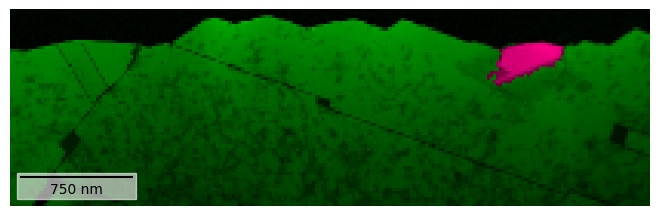

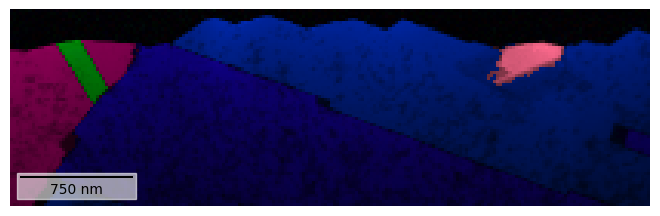

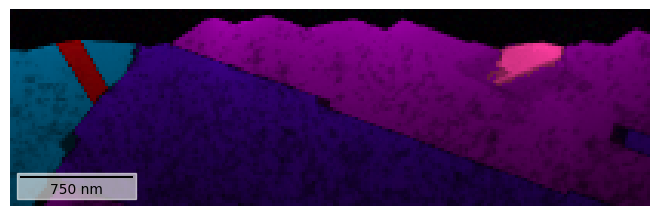

In [45]:
oris_z = key_z.orientation2color(oris)[:,0,:]
xmap.plot(oris_z, overlay=corrs, remove_padding=True)
oris_x = key_x.orientation2color(oris)[:,0,:]
xmap.plot(oris_x, overlay=corrs, remove_padding=True)
oris_y = key_y.orientation2color(oris)[:,0,:]
xmap.plot(oris_y, overlay=corrs, remove_padding=True)